# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators
import alpaca_trade_api as trade_api
import os
import pandas as pd


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Bollinger Band configuration
bollinger_band_window = 20
num_standard_deviation = 2

# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv, bollinger_band_window, num_standard_deviation)


<AxesSubplot:title={'center':'TWOU Bollinger Bands'}, xlabel='Date', ylabel='Price (USD)'>

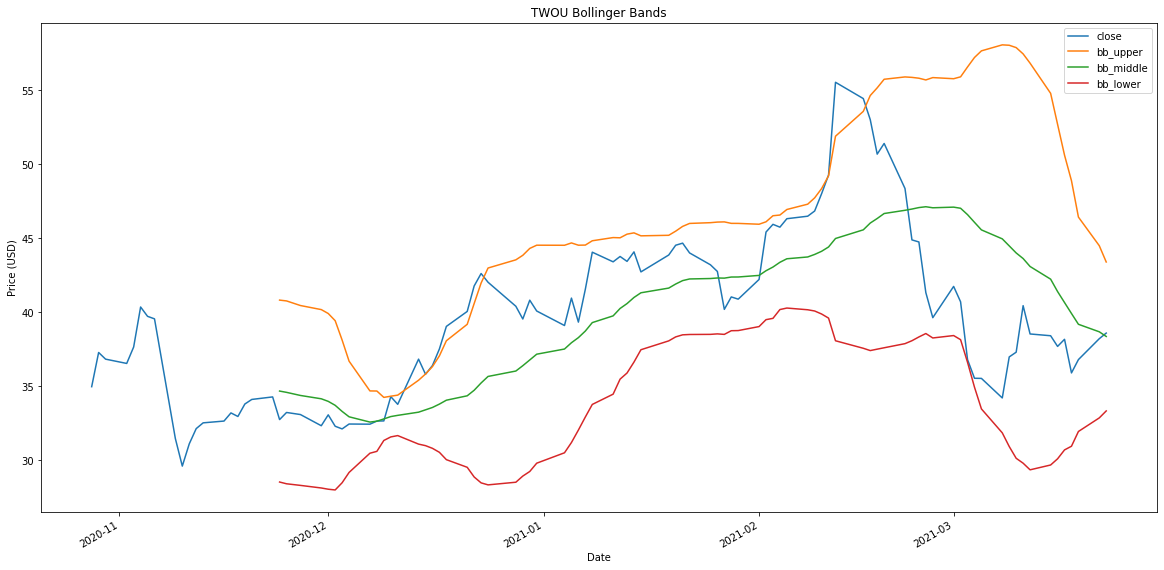

In [8]:
df_updated[['close', 'bb_upper', 'bb_middle', 'bb_lower']].plot(figsize=(20,10), title=f'{ticker} Bollinger Bands', xlabel='Date', ylabel='Price (USD)')


## Keltner Channels


In [9]:
# Generate average true range values
df = indicators.keltner_channel_generator(df_updated)


In [10]:
df.tail()


,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,atr,kc_upper,kc_middle,kc_lower
time,,,,,,,,,,,,
2021-03-17 00:00:00-04:00,37.25,38.79,36.21,38.17,1233887,50.599509,40.6510,30.702491,3.171649,46.439991,40.096693,33.753396
2021-03-18 00:00:00-04:00,36.38,37.85,35.76,35.90,1722342,48.873291,39.9125,30.951709,3.061009,45.819001,39.696984,33.574967
2021-03-19 00:00:00-04:00,35.94,37.12,35.11,36.80,1838363,46.419111,39.1830,31.946889,2.958050,45.337165,39.421066,33.504966
2021-03-22 00:00:00-04:00,36.82,38.78,36.80,38.21,1247563,44.488656,38.6760,32.863344,2.808704,44.923129,39.305720,33.688312
2021-03-23 00:00:00-04:00,38.72,39.30,37.91,38.59,1048618,43.388326,38.3615,33.334674,NaN,NaN,39.237553,NaN
